
### stacked map of galaxy pairs from pair catalog


Stacking pairs:   0%|          | 1712/995181 [00:00<07:27, 2220.25it/s]

1380: Theta less than zero encountered: -0.007014819132025954


Stacking pairs:   2%|▏         | 18574/995181 [00:08<07:15, 2242.11it/s]

18331: Theta less than zero encountered: -0.024710955487568822


Stacking pairs:   2%|▏         | 20191/995181 [00:09<07:03, 2300.09it/s]

19799: Theta less than zero encountered: -0.03143178904598009


Stacking pairs:   3%|▎         | 26939/995181 [00:12<07:06, 2269.02it/s]

26712: Theta less than zero encountered: -0.0005221829829004156


Stacking pairs:   3%|▎         | 29029/995181 [00:13<07:04, 2278.24it/s]

28583: Theta less than zero encountered: -0.003347620567894698


Stacking pairs:   3%|▎         | 29488/995181 [00:13<07:21, 2185.96it/s]

29087: Theta less than zero encountered: -0.025815730054075288
29493: Theta less than zero encountered: -0.0065325388270839274


Stacking pairs:   3%|▎         | 29946/995181 [00:13<07:11, 2235.20it/s]

29626: Theta less than zero encountered: -0.009528978761352723
29968: Theta less than zero encountered: -0.027242401880363684


Stacking pairs:   3%|▎         | 32248/995181 [00:14<07:03, 2276.06it/s]

31902: Theta less than zero encountered: -0.0029444571113180747


Stacking pairs:   3%|▎         | 33376/995181 [00:15<07:09, 2236.86it/s]

33014: Theta less than zero encountered: -0.0074866174243414


Stacking pairs:   4%|▎         | 36134/995181 [00:16<06:57, 2297.73it/s]

35716: Theta less than zero encountered: -0.003370296789958304


Stacking pairs:   4%|▍         | 39595/995181 [00:17<06:53, 2308.42it/s]

39328: Theta less than zero encountered: -0.024870122218705427


Stacking pairs:   5%|▍         | 46005/995181 [00:20<07:00, 2258.86it/s]

45656: Theta less than zero encountered: -0.020237850641454107
45657: Theta less than zero encountered: -0.020164630121562506
45951: Theta less than zero encountered: -0.022267163954789504


Stacking pairs:   6%|▌         | 57378/995181 [00:25<06:42, 2330.21it/s]

56939: Theta less than zero encountered: -0.0035553240038805767
56940: Theta less than zero encountered: -0.0035431886047362416


Stacking pairs:   7%|▋         | 74195/995181 [00:32<06:24, 2392.65it/s]

73785: Theta less than zero encountered: -0.009079099035133731


Stacking pairs:  10%|▉         | 96060/995181 [00:42<06:19, 2368.98it/s]

95710: Theta less than zero encountered: -0.0005313595125293414


Stacking pairs:  10%|▉         | 97007/995181 [00:42<06:22, 2346.25it/s]

96684: Theta less than zero encountered: -0.0004194980264299002


Stacking pairs:  10%|▉         | 97943/995181 [00:43<06:34, 2276.06it/s]

97478: Theta less than zero encountered: -0.015813174709152108


Stacking pairs:  10%|▉         | 99321/995181 [00:43<06:41, 2231.42it/s]

98916: Theta less than zero encountered: -0.0009518948098616706
98917: Theta less than zero encountered: -0.0015387744456830015


Stacking pairs:  17%|█▋        | 169973/995181 [01:14<05:43, 2405.29it/s]

169511: Theta less than zero encountered: -0.018071161172462758


Stacking pairs:  26%|██▌       | 257992/995181 [01:54<09:27, 1300.14it/s]

257848: Theta less than zero encountered: -9.545121677874158e-05


Stacking pairs:  26%|██▋       | 261487/995181 [01:56<05:45, 2123.81it/s]

261114: Theta less than zero encountered: -0.0013750492302661871


Stacking pairs:  28%|██▊       | 275320/995181 [02:02<05:19, 2254.51it/s]

275073: Theta less than zero encountered: -0.0170341240876689
275074: Theta less than zero encountered: -0.01591433057052268


Stacking pairs:  30%|██▉       | 294275/995181 [02:10<05:06, 2283.19it/s]

293950: Theta less than zero encountered: -0.0025810232879355318


Stacking pairs:  35%|███▌      | 350774/995181 [02:35<04:36, 2333.24it/s]

350522: Theta less than zero encountered: -0.013258836907517495


Stacking pairs:  36%|███▌      | 360474/995181 [02:39<04:32, 2327.62it/s]

360146: Theta less than zero encountered: -0.0010053371756595481


Stacking pairs:  37%|███▋      | 364461/995181 [02:41<04:37, 2272.27it/s]

364050: Theta less than zero encountered: -0.002683982052339273


Stacking pairs:  38%|███▊      | 379711/995181 [02:48<04:31, 2270.94it/s]

379430: Theta less than zero encountered: -0.014582926168383362


Stacking pairs:  38%|███▊      | 381566/995181 [02:49<04:25, 2313.29it/s]

381206: Theta less than zero encountered: -0.01678235827000365


Stacking pairs:  39%|███▊      | 385220/995181 [02:51<04:49, 2103.39it/s]

384928: Theta less than zero encountered: -0.009566670086401767


Stacking pairs:  39%|███▉      | 386715/995181 [02:51<04:40, 2165.89it/s]

386407: Theta less than zero encountered: -0.0047146176159263056


Stacking pairs:  39%|███▉      | 387637/995181 [02:52<04:27, 2268.49it/s]

387268: Theta less than zero encountered: -0.015706876021490252


Stacking pairs:  40%|███▉      | 393098/995181 [02:54<04:15, 2359.92it/s]

392856: Theta less than zero encountered: -0.01451266162974996


Stacking pairs:  40%|███▉      | 393802/995181 [02:54<04:21, 2300.99it/s]

393433: Theta less than zero encountered: -0.00042687880874708563


Stacking pairs:  40%|████      | 401754/995181 [02:58<04:57, 1996.53it/s]

401482: Theta less than zero encountered: -0.0032041922689864423
401483: Theta less than zero encountered: -0.0019170250652336654


Stacking pairs:  41%|████      | 406412/995181 [03:01<04:59, 1963.64it/s]

406190: Theta less than zero encountered: -0.01237020321024228


Stacking pairs:  41%|████▏     | 410894/995181 [03:03<04:32, 2142.46it/s]

410551: Theta less than zero encountered: -0.014766437810717166


Stacking pairs:  42%|████▏     | 418644/995181 [03:06<04:18, 2234.32it/s]

418313: Theta less than zero encountered: -0.010969654484924186


Stacking pairs:  43%|████▎     | 431414/995181 [03:12<04:09, 2262.65it/s]

431065: Theta less than zero encountered: -0.004255708082631192


Stacking pairs:  44%|████▎     | 434112/995181 [03:14<04:14, 2208.52it/s]

433764: Theta less than zero encountered: -0.01817225024476459


Stacking pairs:  44%|████▍     | 436464/995181 [03:15<04:42, 1980.67it/s]

436167: Theta less than zero encountered: -0.0010352683983042492


Stacking pairs:  45%|████▍     | 447645/995181 [03:20<04:12, 2166.48it/s]

447407: Theta less than zero encountered: -0.023728858382573523


Stacking pairs:  46%|████▌     | 453660/995181 [03:23<04:14, 2131.59it/s]

453266: Theta less than zero encountered: -8.834241718085705e-05


Stacking pairs:  46%|████▌     | 454083/995181 [03:23<04:23, 2054.22it/s]

453825: Theta less than zero encountered: -0.010327418470075173


Stacking pairs:  46%|████▌     | 455677/995181 [03:24<04:05, 2194.40it/s]

455400: Theta less than zero encountered: -6.147313626755546e-06


Stacking pairs:  46%|████▌     | 459526/995181 [03:26<04:08, 2157.34it/s]

459247: Theta less than zero encountered: -0.00048060456024346017


Stacking pairs:  48%|████▊     | 473331/995181 [03:32<04:10, 2085.64it/s]

473090: Theta less than zero encountered: -0.004202864453628761
473091: Theta less than zero encountered: -0.00485385364552569


Stacking pairs:  49%|████▉     | 488662/995181 [03:40<04:04, 2070.31it/s]

488462: Theta less than zero encountered: -0.004547790582901327


Stacking pairs:  50%|█████     | 501252/995181 [03:45<03:40, 2244.52it/s]

501020: Theta less than zero encountered: -0.007393038885663696


Stacking pairs:  57%|█████▋    | 569872/995181 [04:17<03:20, 2116.90it/s]

569595: Theta less than zero encountered: -0.0009930577746791612


Stacking pairs:  65%|██████▌   | 649001/995181 [04:55<02:48, 2051.98it/s]

648625: Theta less than zero encountered: -0.003085922599654148


Stacking pairs:  69%|██████▉   | 689132/995181 [05:13<02:34, 1982.26it/s]

688826: Theta less than zero encountered: -0.006830888449968615


Stacking pairs:  70%|██████▉   | 694465/995181 [05:16<02:12, 2264.15it/s]

694101: Theta less than zero encountered: -0.005816591947250814
694102: Theta less than zero encountered: -0.005701281158816842


Stacking pairs:  70%|██████▉   | 695565/995181 [05:17<02:39, 1876.64it/s]

695363: Theta less than zero encountered: -0.004306174892822289
695364: Theta less than zero encountered: -0.0030451061462702495


Stacking pairs:  77%|███████▋  | 768436/995181 [05:52<01:47, 2099.79it/s]

768257: Theta less than zero encountered: -0.004018595062340799


Stacking pairs:  79%|███████▉  | 786160/995181 [06:01<01:30, 2298.75it/s]

785951: Theta less than zero encountered: -0.023968827595930813


Stacking pairs:  80%|███████▉  | 794012/995181 [06:04<01:33, 2154.96it/s]

793691: Theta less than zero encountered: -0.024819018009668226


Stacking pairs:  92%|█████████▏| 915384/995181 [07:01<00:35, 2226.53it/s]

915129: Theta less than zero encountered: -0.010349138645017214


Stacking pairs:  92%|█████████▏| 918022/995181 [07:02<00:35, 2158.03it/s]

917743: Theta less than zero encountered: -0.0010600065804474929


Stacking pairs:  92%|█████████▏| 920510/995181 [07:03<00:32, 2268.06it/s]

920069: Theta less than zero encountered: -0.005985052567933626
920070: Theta less than zero encountered: -0.004527099221433039


Stacking pairs:  93%|█████████▎| 926059/995181 [07:06<00:31, 2165.88it/s]

925822: Theta less than zero encountered: -0.001790303142184996


Stacking pairs:  94%|█████████▍| 939552/995181 [07:12<00:25, 2180.38it/s]

939253: Theta less than zero encountered: -0.008909103060899315


Stacking pairs:  96%|█████████▋| 959791/995181 [07:21<00:15, 2233.88it/s]

959550: Theta less than zero encountered: -0.007162313876767901


Stacking pairs:  97%|█████████▋| 962235/995181 [07:22<00:15, 2144.67it/s]

961878: Theta less than zero encountered: -0.007851019600040606


Stacking pairs:  97%|█████████▋| 963334/995181 [07:23<00:14, 2182.30it/s]

962968: Theta less than zero encountered: -0.007035437013022523


Stacking pairs: 100%|██████████| 995181/995181 [07:38<00:00, 2172.72it/s]


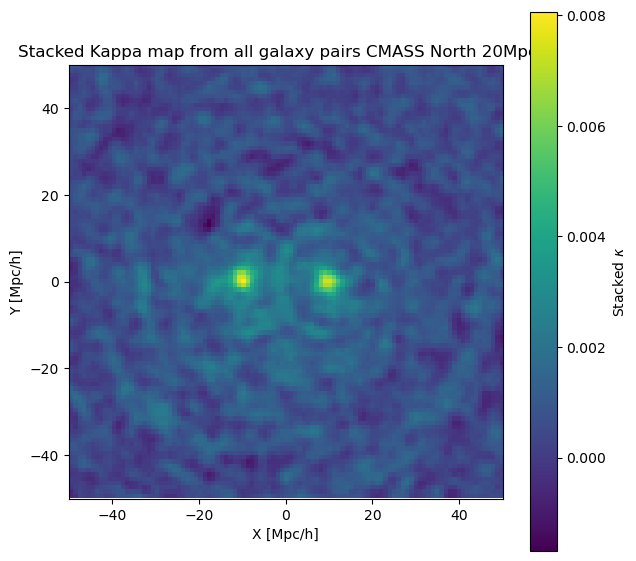

In [109]:
import numpy as np
import healpy as hp
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # progress bar

# --- Load catalog and map as before ---
# pairs = pd.read_csv('data/galaxy_pairs_catalog_5hmpc.csv')

# --- Settings ---
distance = 20
dataset = "BOSS"
if dataset == "eBOSS":
    pairs_NGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_{distance}hmpc.csv')
    pairs_SGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_SGC_{distance}hmpc.csv')
    pairs = pd.concat([pairs_NGC, pairs_SGC], ignore_index=True)
elif dataset == "BOSS":
    catalog, region = "CMASS", "North"
    pairs = pd.read_csv(f"data/paircatalogs/galaxy_pairs_catalog_CMASS_{region}_{distance}_{distance-2}_{distance+2}hmpc.csv")
else:
    raise ValueError("dataset must be eBOSS or BOSS")

alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"
nside = 2048

alm_data = hp.read_alm(alm_file)
lmax = hp.Alm.getlmax(len(alm_data))
kmap = hp.alm2map(hp.smoothalm(alm_data, fwhm=np.radians(8/60)), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Grid parameters ---
grid_size = 100.0 # Mpc/h box size
grid_res = 101
half_size = grid_size / 2
X_vals = np.linspace(-half_size, half_size, grid_res)
Y_vals = np.linspace(-half_size, half_size, grid_res)
X_grid, Y_grid = np.meshgrid(X_vals, Y_vals)

# Initialize stack accumulators
kappa_stack_sum = np.zeros((grid_res, grid_res))
weight_stack_sum = np.zeros((grid_res, grid_res))

# Loop over all pairs
for idx, pair in tqdm(pairs.iterrows(), total=len(pairs), desc="Stacking pairs"):
    # Extract pair data (convert to radians)
    l1, b1, z1 = np.deg2rad(pair['l1']), np.deg2rad(pair['b1']), pair['z1']
    l2, b2, z2 = np.deg2rad(pair['l2']), np.deg2rad(pair['b2']), pair['z2']

    # --- Enforce consistent ordering of longitudes ---
    # Compute raw difference, wrapped into [-π, π]
    dl_raw = (l2 - l1 + np.pi) % (2*np.pi) - np.pi

    # If "l2 is to the left of l1", swap them
    if dl_raw < 0:
        l1, l2 = l2, l1
        b1, b2 = b2, b1
        z1, z2 = z2, z1
        dl_raw = -dl_raw   # now positive

    # --- Midpoint (wrap-safe) ---
    lc = l1 + 0.5 * dl_raw
    bc = 0.5 * (b1 + b2)
    zbar = 0.5 * (z1 + z2)
    Dc = cosmo.comoving_distance(zbar).value * cosmo.h  # Mpc/h

    # --- Rotation angle θ ---
    dl = dl_raw * np.cos(bc)
    db = (b2 - b1)
    norm = np.hypot(dl, db)
    cos_theta, sin_theta = dl / norm, db / norm

    # Inverse transform (X,Y) -> (l,b)
    dl_cosbc = (cos_theta * (X_grid / Dc)) - (sin_theta * (Y_grid / Dc))
    db_grid = (sin_theta * (X_grid / Dc)) + (cos_theta * (Y_grid / Dc))
    l_grid = lc + dl_cosbc / np.cos(bc)
    b_grid = bc + db_grid

    # Convert to degrees
    l_grid_deg = np.rad2deg(l_grid)
    b_grid_deg = np.rad2deg(b_grid)

    # Convert to Healpix pixels
    l_grid_deg_wrapped = np.mod(l_grid_deg, 360)
    theta = np.radians(90 - b_grid_deg)
    if np.min(theta) < 0:
        print(f"{idx}: Theta less than zero encountered: {np.min(theta)}")
        continue
    if np.max(theta) > np.pi:
        print(f"{idx}: Theta greater than zero encountered: {np.max(theta)}")
        continue
    phi = np.radians(l_grid_deg_wrapped)
    # theta = np.clip(theta, 0, np.pi)  # Ensure valid range
    pix = hp.ang2pix(nside, theta.ravel(), phi.ravel())

    # Sample kappa and mask
    kappa_vals = kmap[pix].reshape(grid_res, grid_res)
    mask_vals = mask[pix].reshape(grid_res, grid_res)

    # Mask out invalid pixels
    valid_mask = (mask_vals != 0) & np.isfinite(kappa_vals)
    kappa_vals[~valid_mask] = 0.0

    # Weights: if you have pair weights, use them here
    weight = 1.0  # equal weighting for now

    # Accumulate weighted sum and weights
    kappa_stack_sum += weight * kappa_vals
    weight_stack_sum += weight * valid_mask.astype(float)

# Avoid division by zero
nonzero = weight_stack_sum > 0
kappa_stack_mean = np.zeros_like(kappa_stack_sum)
kappa_stack_mean[nonzero] = kappa_stack_sum[nonzero] / weight_stack_sum[nonzero]

# Plot stacked map
plt.figure(figsize=(7,7))
extent = [-half_size, half_size, -half_size, half_size]
im = plt.imshow(kappa_stack_mean, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(im, label=r'Stacked $\kappa$')
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.title(f'Stacked Kappa map from all galaxy pairs {catalog} {region} {distance}Mpc/h')
plt.show()

In [110]:
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from helper import symmetrize_map
from helper import radial_profile

# kappa_smooth = gaussian_filter(kappa_stack_mean, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_stack_mean)

/Users/carolinewu/PycharmProjects/astrophysics/helper.py:113: RuntimeWarning: invalid value encountered in divide
  kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)


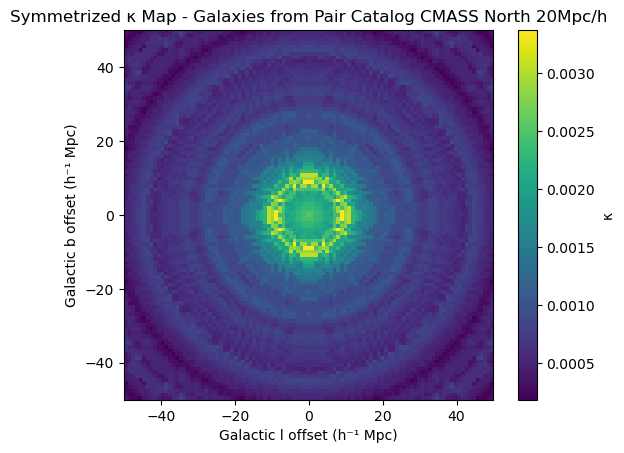

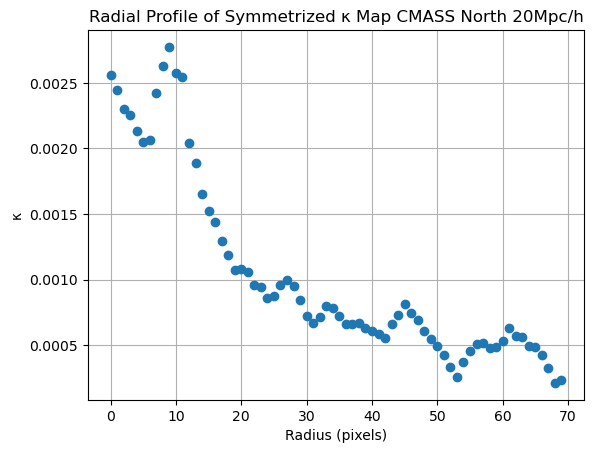

(array([0.00256329, 0.00244649, 0.00230332, 0.00225726, 0.00212982,
        0.00205091, 0.0020661 , 0.00242467, 0.00263174, 0.00277395,
        0.00257559, 0.00254532, 0.00203956, 0.00188811, 0.00165617,
        0.00152676, 0.00143935, 0.00129641, 0.00118837, 0.00107315,
        0.00107819, 0.00105791, 0.00096229, 0.00094332, 0.00086042,
        0.00087947, 0.00095941, 0.00099446, 0.0009532 , 0.00084584,
        0.00072226, 0.00067156, 0.0007181 , 0.00080347, 0.00078175,
        0.00072743, 0.00066132, 0.00066002, 0.00066991, 0.00062934,
        0.0006121 , 0.00058367, 0.00055586, 0.00066597, 0.00073037,
        0.00081781, 0.00075008, 0.00069106, 0.00060894, 0.00054593,
        0.00049738, 0.00042861, 0.00033518, 0.00026229, 0.00037342,
        0.00045934, 0.00051306, 0.00051586, 0.000477  , 0.00048842,
        0.00053106, 0.00063502, 0.00057058, 0.00056059, 0.00049694,
        0.00048786, 0.00042859, 0.00032687, 0.00021373, 0.00023548,
        0.00029964]),
 None)

In [111]:
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Symmetrized κ Map - Galaxies from Pair Catalog {catalog} {region} {distance}Mpc/h")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title=f"Radial Profile of Symmetrized κ Map {catalog} {region} {distance}Mpc/h", zoom=70)

In [112]:
# The next section explores reflection symmetry enforcement
# The next graph is the one that I attached to the google doc

In [113]:
def reflect_symmetrize_map(kappa_map):
    """
    Apply reflection symmetry: for every (x,y), average values at
    (+/-x, +/-y) and assign the average to all four.
    Assumes kappa_map is square with odd dimensions (so center is defined).
    """
    sym_map = np.copy(kappa_map)
    n = kappa_map.shape[0]
    center = n // 2  # integer index of the center pixel

    for i in range(center + 1):       # only need to loop half
        for j in range(center + 1):
            # Offsets from the center
            di, dj = i - center, j - center

            # Four symmetric positions
            coords = [
                (center + di, center + dj),
                (center - di, center + dj),
                (center + di, center - dj),
                (center - di, center - dj),
            ]

            # Extract values
            vals = [kappa_map[x, y] for x, y in coords]

            # Compute mean
            avg_val = np.mean(vals)

            # Assign average back
            for x, y in coords:
                sym_map[x, y] = avg_val

    return sym_map

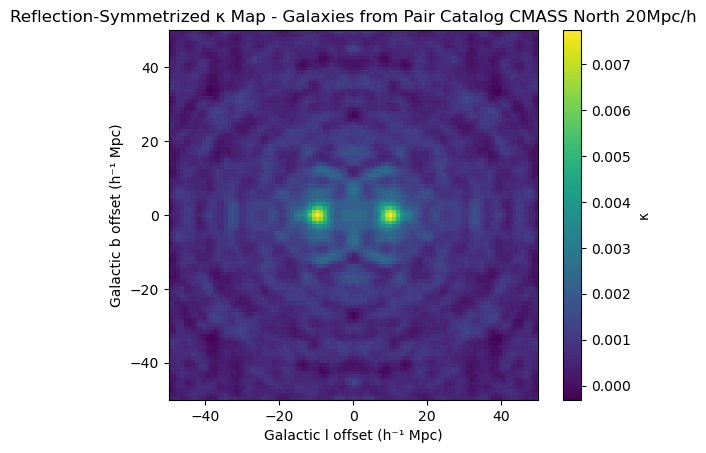

In [114]:
# --- Plot symmetrized map (reflection symmetry) ---
kappa_sym = reflect_symmetrize_map(kappa_stack_mean)
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Reflection-Symmetrized κ Map - Galaxies from Pair Catalog {catalog} {region} {distance}Mpc/h")
plt.show()

In [115]:
pd.DataFrame(kappa_sym).to_csv(fr"data/kappa_sym_{distance}_NGCSGC.csv", index=True)

In [116]:
def reflect_x_symmetrize_map(kappa_map):
    """
    Enforce reflection symmetry only across the Y axis:
    average (+x,y) and (-x,y).
    """
    sym_map = np.copy(kappa_map)
    n = kappa_map.shape[0]
    center = n // 2

    for i in range(center + 1):
        for j in range(n):
            di = i - center
            coords = [
                (center + di, j),
                (center - di, j),
            ]
            vals = [kappa_map[x, y] for x, y in coords]
            avg_val = np.mean(vals)
            for x, y in coords:
                sym_map[x, y] = avg_val
    return sym_map

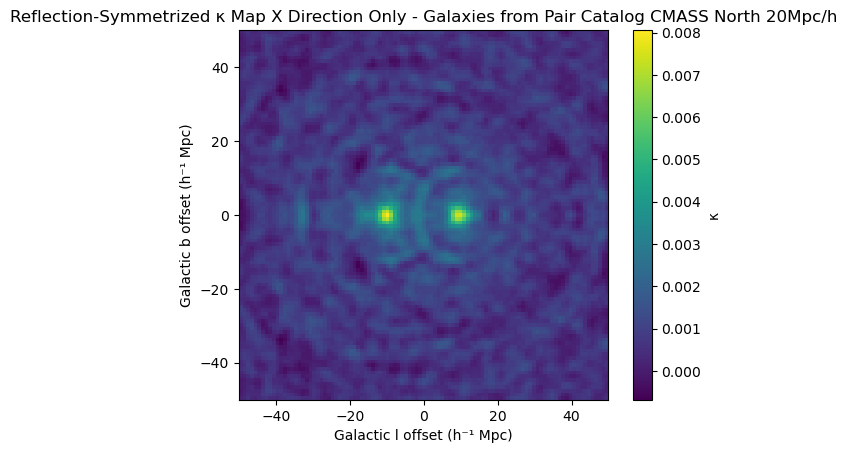

In [117]:
kappa_sym = reflect_x_symmetrize_map(kappa_stack_mean)
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Reflection-Symmetrized κ Map X Direction Only - Galaxies from Pair Catalog {catalog} {region} {distance}Mpc/h")
plt.show()

In [118]:
def reflect_x_symmetrize_map(kappa):
    """
    Enforce reflection symmetry across the Y axis (left/right):
    average (+x, y) with (-x, y). Works for odd-sized square maps.
    """
    h, w = kappa.shape
    assert h == w and (w % 2 == 1), "Map must be square with odd dim."
    c = w // 2  # center column

    sym = kappa.copy()

    # Left half incl. center vs right half reversed (for column mirror)
    left  = kappa[:, :c+1]           # columns [0..c]
    right = np.fliplr(kappa)[:, :c+1]  # mirror of columns [c..end]

    avg = 0.5 * (left + right)

    # Put averaged half back, then mirror it to the other side
    sym[:, :c+1] = avg
    sym[:, c:]   = np.fliplr(avg)
    return sym

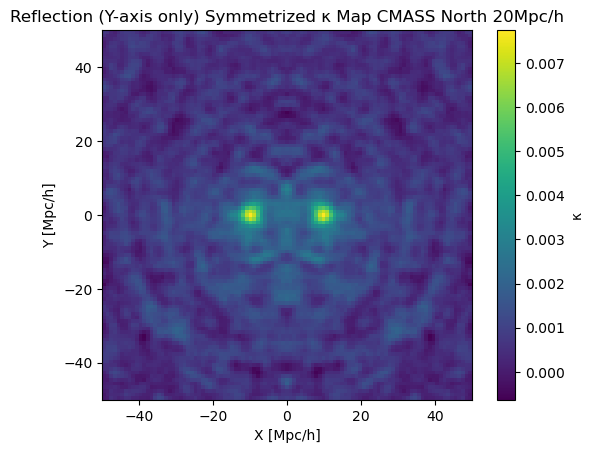

In [119]:
# kappa_smooth = gaussian_filter(kappa_stack_mean, sigma=2)
kappa_sym = reflect_x_symmetrize_map(kappa_stack_mean)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("X [Mpc/h]"); plt.ylabel("Y [Mpc/h]")
plt.title(f"Reflection (Y-axis only) Symmetrized κ Map {catalog} {region} {distance}Mpc/h")
plt.show()